# Tutorial

The `amisrsynthdata` package is designed to create synthetic data files that mimic the structure of AMISR data.  Users specify both the ionospheric state and the radar mode in a configuration file, which can either be loaded into python and used to initialize the `amisrsynthdata` classes or used to run `amisrsynthdata` directly from the command line.  This tutorial uses the [example configuration file](https://github.com/amisr/amisrsynthdata/blob/main/example_synth_config.yaml) available on the project's [GitHub page](https://github.com/amisr/amisrsynthdata).  Specific instructions and descriptions of different fields in the configuration file are available in th [package documentation](https://amisrsynthdata.readthedocs.io/en/latest/configfile.html).

## Python

Import `amisrsynthdata` modules and other packages used by this tutorial.

In [1]:
import datetime as dt
import yaml
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from amisrsynthdata.radar import Radar
from amisrsynthdata.ionosphere import Ionosphere
from amisrsynthdata.syntheticdata import SyntheticData

Load configuration file.

In [2]:
config_file = 'example_synth_config.yaml'
with open(config_file, 'r') as cf:
    config = yaml.load(cf, Loader=yaml.FullLoader)


### Radar Class
This class lets you access features of the radar configuration.

BeamCode  Azimuth   Elevation
65066     14.04     90.0      
64964     -154.3    77.5      
64157     -34.69    66.09     
64016     75.03     65.56     
90001     120.0     60.0      
90002     180.0     50.0      


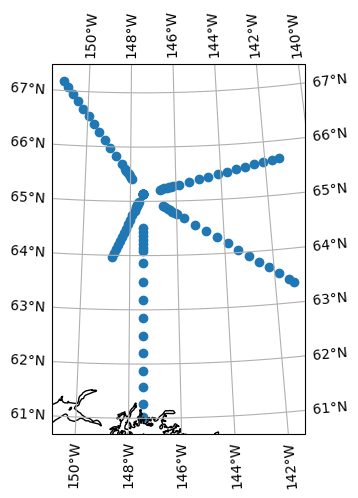

In [3]:
rad = Radar(config)

# Print BeamCode array
print('BeamCode  Azimuth   Elevation')
for bc, az, el in zip(rad.beam_codes, rad.beam_azimuth, rad.beam_elevation):
    print(f'{bc:<10}{az:<10}{el:<10}')

# Creat map of the beam positions
fig = plt.figure()
proj = ccrs.AzimuthalEquidistant(central_latitude=rad.site_lat, central_longitude=rad.site_lon)
ax = fig.add_subplot(111, projection=proj)
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.scatter(rad.lon, rad.lat, transform=ccrs.Geodetic())


### Ionosphere Class
This class contains callable functions for the ionospheric state parameters.

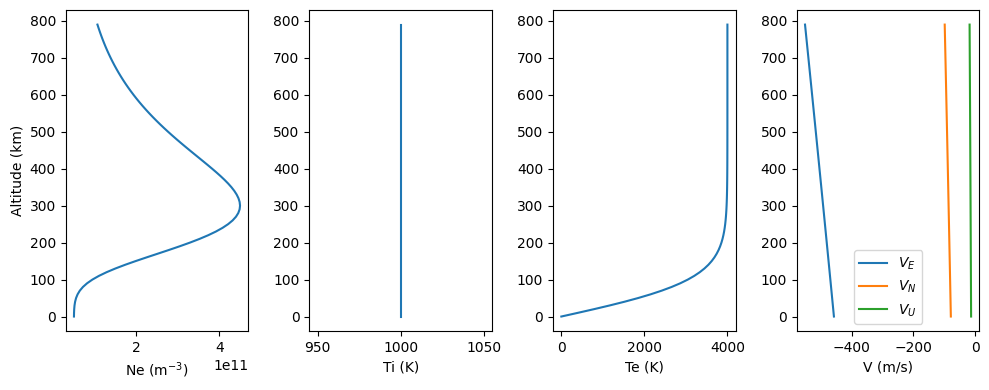

In [4]:
iono = Ionosphere(config)

# Calculate ionospheric parameters at a particular location and time
glat = 65.0
glon = 100.0
alt = np.arange(0., 800., 10.)*1000.
utime = (dt.datetime(2016, 9, 13, 0, 5, 0)-dt.datetime.utcfromtimestamp(0)).total_seconds()
Ne = iono.density(utime, glat, glon, alt)
Vi = iono.velocity(utime, glat, glon, alt)
Te = iono.etemp(utime, glat, glon, alt)
Ti = iono.itemp(utime, glat, glon, alt)

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(141)
ax.plot(Ne, alt/1000.)
ax.set_xlabel(r'Ne (m$^{-3}$)')
ax.set_ylabel('Altitude (km)')
ax = fig.add_subplot(142)
ax.plot(Ti, alt/1000.)
ax.set_xlabel('Ti (K)')
ax = fig.add_subplot(143)
ax.plot(Te, alt/1000.)
ax.set_xlabel('Te (K)')
ax = fig.add_subplot(144)
ax.plot(Vi[:,0], alt/1000., label=r'$V_E$')
ax.plot(Vi[:,1], alt/1000., label=r'$V_N$')
ax.plot(Vi[:,2], alt/1000., label=r'$V_U$')
ax.legend()
ax.set_xlabel('V (m/s)')
fig.tight_layout()


Note that uniform functions were chosen for ion temperature and velocity, hence the minimal variation in altitude.  The velocity panel shows some variation because the uniform velocity function assumes a uniform $\vec{E}\times\vec{B}$ drift velocity which maps along magnetic field lines.

### Synthetic Data Class
This class contains instances of both the `Radar` and `Ionosphere` class, as well as arrays of the synthetic radar measurements.

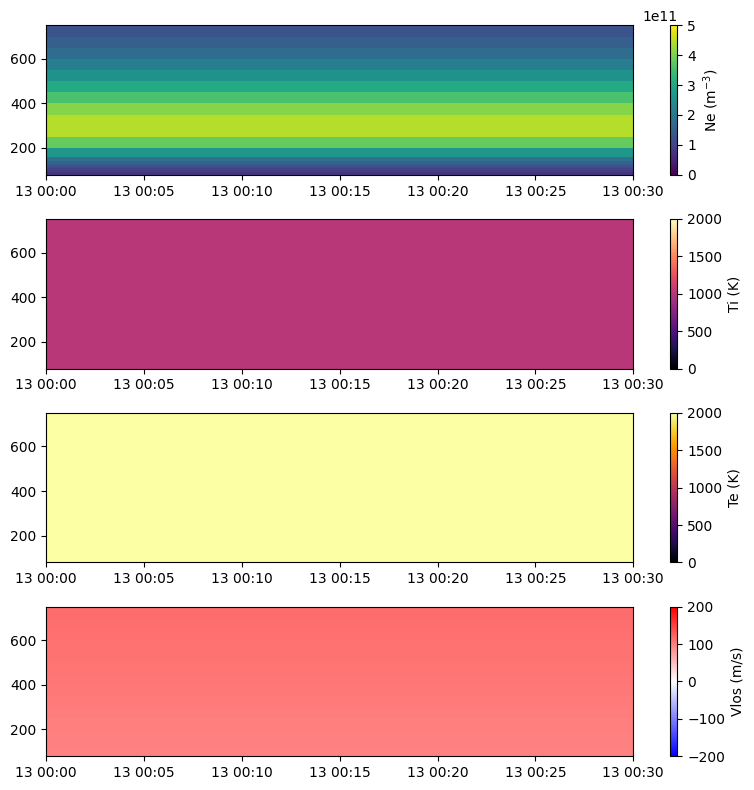

In [5]:
sd = SyntheticData(config)

time = np.mean(sd.utime, axis=1).astype('datetime64[s]')

beam = 0

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(411)
c = ax.pcolormesh(time, sd.radar.alt[beam,:]/1000., sd.ne[:,beam,:].T, vmin=0., vmax=5.e11, cmap='viridis')
fig.colorbar(c, label=r'Ne (m$^{-3}$)')
ax = fig.add_subplot(412)
c = ax.pcolormesh(time, sd.radar.alt[beam,:]/1000., sd.ti[:,beam,:].T, vmin=0., vmax=2000., cmap='magma')
fig.colorbar(c, label='Ti (K)')
ax = fig.add_subplot(413)
c = ax.pcolormesh(time, sd.radar.alt[beam,:]/1000., sd.te[:,beam,:].T, vmin=0., vmax=2000., cmap='inferno')
fig.colorbar(c, label='Te (K)')
ax = fig.add_subplot(414)
c = ax.pcolormesh(time, sd.radar.alt[beam,:]/1000., sd.vlos[:,beam,:].T, vmin=-200., vmax=200., cmap='bwr')
fig.colorbar(c, label='Vlos (m/s)')
fig.tight_layout()


None of the ionospheric state functions chosen for this simple example vary in time.

## Command Line

To run the AMISR synthetic data generator, simply call `amisrsynthdata` from the command line with the configuration file as a positional argument.

In [6]:
! amisrsynthdata 'example_synth_config.yaml'

This should produce the output file `synthetic_data.h5`, which mirrors the format of AMISR datafiles downloaded from the [SRI AMISR database](https://data.amisr.com/database/).